In [2]:
:extension DerivingVia TypeFamilies DerivingStrategies GeneralizedNewtypeDeriving FlexibleContexts OverloadedStrings

import Diagrams.Prelude
import Control.Monad ((>=>))
import Data.Bifunctor (second)
import Data.Tuple (swap)
import Data.String (IsString)
import Data.Maybe (fromMaybe)
import IHaskell.Display.Diagrams
import Diagrams.Backend.Cairo (B)
import Data.Tree (Tree(Node), Forest, rootLabel, subForest, drawForest)

### Type definitions

In [7]:
newtype Location = Location { name :: String } deriving newtype (Eq, Show, IsString)

data BellPair = Location :~: Location

instance Show BellPair where
    show (l1 :~: l2) = name l1 <> "," <> name l2
instance Eq BellPair where
    l1 :~: l2 == l1' :~: l2' = (l1 , l2) == (l1', l2') || (l2, l1) == (l1', l2') 

newtype History = History { getForest :: Forest BellPair } deriving newtype (Show, Semigroup, Monoid) 


### Auxiliary functions

In [8]:
findTreeRoot :: BellPair -> [Tree BellPair] -> Maybe (Tree BellPair, [Tree BellPair])
findTreeRoot p [] = Nothing
findTreeRoot p (t : ts) | rootLabel t == p = Just (t, ts)
                        | otherwise = second (t :) <$> findTreeRoot p ts

### Main policy definitions

In [18]:
data Policy 
    = Swap Location (Location, Location)
    | Transmit Location (Location, Location)
    | Distill (Location, Location)
    | Identity (Location, Location)
    | Sequence Policy Policy
    | Parallel Policy Policy
    | Create Location
    
instance Semigroup Policy where
    (<>) = Sequence

(<||>) = Parallel

In [27]:
applyPolicy :: Policy -> History -> History

applyPolicy (Swap l (l1, l2)) (History ts) = fromMaybe (History []) $
    findTreeRoot (l :~: l1) ts >>= \(t, ts) ->
        findTreeRoot (l :~: l2) ts >>= \(t', ts) ->
            return $ History [Node (l1 :~: l2) [t, t']]
            
applyPolicy (Transmit l (l1, l2)) (History ts) = fromMaybe (History []) $
    findTreeRoot (l :~: l) ts >>= \(t, ts) ->
        return $ History [Node (l1 :~: l2) [t]]
        
applyPolicy (Create l) h = History [Node (l :~: l) []]

applyPolicy (Distill (l1, l2)) (History ts) = fromMaybe (History []) $
    findTreeRoot (l1 :~: l2) ts >>= \(t, ts) ->
        findTreeRoot (l1 :~: l2) ts >>= \(t', ts) ->
            return $ History [Node (l1 :~: l2) [t, t']]
            
applyPolicy (Identity (l1, l2)) (History ts) = fromMaybe (History []) $
    findTreeRoot (l1 :~: l2) ts >>= \(t, ts) ->
        return $ History [t]
        
applyPolicy (Sequence p q) h = applyPolicy q . applyPolicy p $ h

applyPolicy (Parallel p q) h = applyPolicy p h <> applyPolicy q h

### Some drawing code

In [31]:
pairToDiagram bp = (text (show bp) <> rect 4 1) # fontSize (local 0.5) 

treeToDiagram t = 
    let childrenNames = [1..(length $ subForest t :: Int)]
        rootName = 0 :: Int
        subtrees = zipWith (.>>) childrenNames (map treeToDiagram $ subForest t)
      in vsep 1 [pairToDiagram (rootLabel t) # named rootName, hsep 0.5 subtrees # centerX  ] 
          # appEndo (mconcat $ map (\i -> Endo $ connectOutside (i .> rootName) rootName) childrenNames)

historyToDiagram (History ts) = hsep 0.5 (map treeToDiagram ts)

drawPolicy :: Policy -> ManuallySized (Diagram B)
drawPolicy p = withImgWidth 600 . historyToDiagram . applyPolicy p $ History [] 

drawPolicyText :: Policy -> IO ()
drawPolicyText p = putStrLn . drawForest . (fmap . fmap) show . getForest $ applyPolicy p $ History []

## Examples

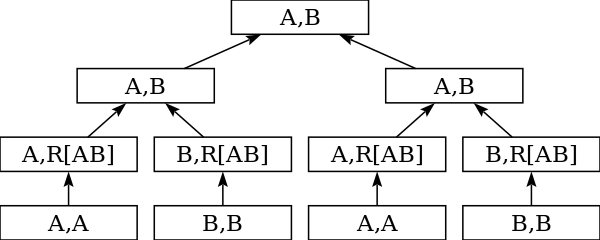

In [36]:
p = (Create "A" <||> Create "B") <> (Transmit "A" ("A", "R[AB]") <||> Transmit "B" ("B", "R[AB]")) <> Swap "R[AB]" ("A", "B")
    
drawPolicy $ (p <||> p) <> Distill ("A", "B")

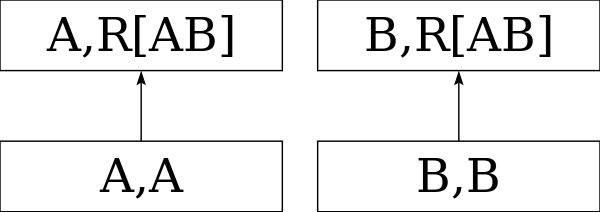

In [37]:
drawPolicy $ (Create "A" <||> Create "B") <> (Transmit "A" ("A", "R[AB]") <||> Transmit "B" ("B", "R[AB]"))

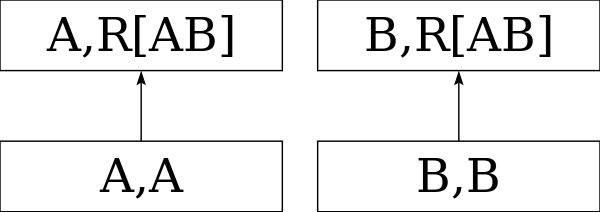

In [39]:
drawPolicy $ 
    (Create "A" <> Transmit "A" ("A", "R[AB]")) 
    <||> (Create "B" <> Transmit "A" ("A", "R[AB]")) 
    <||> (Create "A" <> Transmit "B" ("B", "R[AB]"))
    <||> (Create "B" <> Transmit "B" ("B", "R[AB]"))

In [40]:
drawPolicy $ 
    (Create "A" <||> Create "B") <> Transmit "A" ("A", "R[AB]") <> Transmit "B" ("B", "R[AB]")

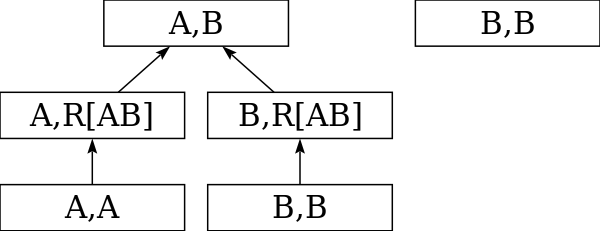

In [44]:
drawPolicy $ 
    Create "A"
    <> (Transmit "A" ("A", "R[AB]") <||> Create "B") 
    <> (Transmit "B" ("B", "R[AB]") <||> Identity ("A", "R[AB]") <||> Create "B")
    <> (Swap "R[AB]" ("A", "B") <||> Identity ("B", "B"))

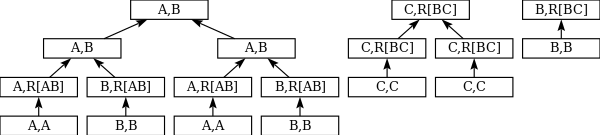

In [50]:
pAB = (Create "A" <||> Create "B") <> (Transmit "A" ("A", "R[AB]") <||> Transmit "B" ("B", "R[AB]")) <> Swap "R[AB]" ("A", "B")
pCR = ((Create "C" <> Transmit "C" ("C", "R[BC]")) <||> (Create "C" <> Transmit "C" ("C", "R[BC]"))) <> Distill ("C", "R[BC]")

drawPolicy $ ((pAB <||> pAB) <> Distill ("A", "B")) <||> (pCR <||> (Create "B" <> Transmit "B" ("B", "R[BC]")) )

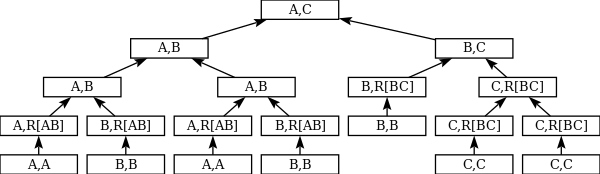

In [ ]:
pAB = (Create "A" <||> Create "B") <> (Transmit "A" ("A", "R[AB]") <||> Transmit "B" ("B", "R[AB]")) <> Swap "R[AB]" ("A", "B")
pCR = ((Create "C" <> Transmit "C" ("C", "R[BC]")) <||> (Create "C" <> Transmit "C" ("C", "R[BC]"))) <> Distill ("C", "R[BC]")
pBC = (pCR <||> (Create "B" <> Transmit "B" ("B", "R[BC]"))) <> Swap "R[BC]" ("B", "C")


drawPolicy $ (((pAB <||> pAB) <> Distill ("A", "B")) <||> pBC ) <> Swap "B" ("A", "C")

## Question

 * Show failures as part of the history? Could be too much of information?
 * Failures in distill and swap?
 * reachability in practice (only with some probability)
 * Simulating the actual run of the policy?
 * Generate the policy from probability